In [1]:
import torch
x = torch.tensor([1., 2., 3., 4., 5., 6.])

import tensorflow as tf
x = tf.constant([1., 2., 3., 4., 5., 6.])

import jax.numpy as jnp
x = jnp.array([1., 2., 3., 4., 5., 6.])

import numpy as np
from numpy.random import randn
x = np.array([1., 2., 3., 4., 5., 6.])

# No matter which framwork you use, you can use the same code
import eagerpy as ep

# Just wrap a native tensor using EagerPy
x = ep.astensor(x)

In [2]:
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

class TimerError(Exception):
    """A custom exception used to report errors in use of Timer class"""

class Timer:
    def __init__(self):
        self._start_time = None
    
    def __enter__(self):
        """Start a new timer as a context manager"""
        self.start()
        return self

    def __exit__(self, *exc_info):
        """Stop the context manager timer"""
        self.stop()


    def start(self):
        """Start a new timer"""
        if self._start_time is not None:
            raise TimerError(f"Timer is running. Use .stop() to stop it")

        self._start_time = time.perf_counter()

    def stop(self):
        """Stop the timer, and report the elapsed time"""
        if self._start_time is None:
            raise TimerError(f"Timer is not running. Use .start() to start it")

        elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        print(f"Elapsed time: {elapsed_time:0.4f} seconds")

In [3]:
def get_dataset(seed, x_dim, freq, samples, scale=1, sep=1):
    np.random.seed(seed)
    mu_0 = randn(x_dim,1) # mean of class 0
    mu_1 = randn(x_dim,1) # mean of class 1
    # print(mu_0, mu_1)
    sig = randn(x_dim,x_dim)/np.sqrt(x_dim) # covariance of class 0
    Sigma = sig@sig.T
    class_0 = scale * mu_0 + sig@randn(x_dim,int(samples*(1-freq)))
    class_1 = scale * mu_1 + sig@randn(x_dim,int(samples*freq))
    X = np.concatenate((class_0,class_1),axis=1)
    Y = np.zeros((2,samples)); Y[0,:int(samples*(1-freq))] = 1; Y[1,-int(samples*freq):] = 1

    return (class_0, class_1, X, Y, mu_0, mu_1, Sigma)


def raw(items):
    return list(map(lambda x: x.raw, items))

In [4]:
seed = 0
x_dim = 5 # dimension of observations
freq = 0.1 # frequency of class 1 samples
samples = 100000 # number of data points
scale = 1
items = get_dataset(seed, x_dim, freq, samples, scale)
items = tuple(map(lambda x: jnp.array(x), items))
items = tuple(map(lambda x: ep.astensor(x), items))
(class_0, class_1, X, Y, mu_0, mu_1, Sigma) = items

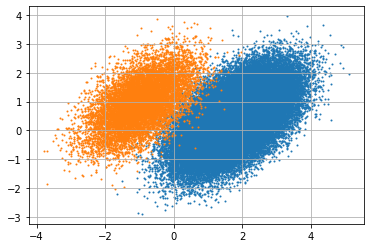

In [5]:
plt.scatter(class_0[0].raw, class_0[1].raw,s=1)
plt.scatter(class_1[0].raw, class_1[1].raw,s=1)
plt.grid()
plt.show()

In [6]:
def run_offline(items, iters, lrs):
    
    class_0, class_1, X, Y, mu_0, mu_1, Sigma = items
    eta, gamma = lrs
    samples = class_0.shape[1] + class_1.shape[1]
    
    w_opt = Sigma.inv()@(mu_0-mu_1)
    w_opt = w_opt/(w_opt.T@(Sigma)@w_opt).sqrt()
    
    def fit(w, l):
        w += eta * (mu_0-mu_1 - l*(Sigma@w))
        l += gamma * w.T@Sigma@w - 1
        
        return w,l
    
    err = np.zeros(iters)
    acc = np.zeros(iters)
    
    w = np.random.randn(x_dim,1)/np.sqrt(x_dim)
    l = np.ones((1,1))
    
    
    w = jnp.array(w)
    l = jnp.array(l)
    w = ep.astensor(w)
    l = ep.astensor(l)
#     err = ep.astensor(err)
#     acc = ep.astensor(acc)
    
    for i_iter in tqdm(range(iters)):
        w, l = fit(w, l)
        print("fit")
#         err[i_iter] = norm(w[:,0] - w_opt[:,0]).square().raw
#         acc[i_iter] = ((w.T@class_0 > 1/2 * w.T@(mu_0+mu_1)).sum()  + (w.T@class_1 < 1/2 * w.T@(mu_0+mu_1)).sum())/samples
        

In [7]:
def norm(x):
    x = ep.astensor(x)
    result = x.square().sum().sqrt()
    return result

In [8]:
eta = 1e-3; gamma = 1e2*eta; iters = int(1e5)

In [ ]:
run_offline(items, iters, (eta, gamma))

  0%|                                                | 0/100000 [00:00<?, ?it/s]

fit


  0%|                                                | 0/100000 [00:00<?, ?it/s]


In [ ]:
# obj = np.zeros(iters)
# err = np.zeros(iters)
# acc = np.zeros(iters)

# @jit(nopython=True)
# def fit(w, l, mu_1, mu_2, Sigma):
#     w = w + eta*(mu_1 - mu_2 - l*Sigma@w)
#     l = l + gam*((w.T@Sigma@w).item() - 1)
    
#     return w, l
        
# def run_offline(mu_1, mu_2, Sigma, eta, gamma, iters):
    
#     w = np.random.randn(x_dim,1)/np.sqrt(x_dim)
#     l = 1
    
#     for i_iter in tqdm(range(iters)):
#         w, l = fit(w, l, mu_1, mu_2, Sigma)
#         obj[i_iter] = (w.T@(mu_1-mu_2))**2/(w.T@Sigma@w)
#         err[i_iter] = np.linalg.norm(w[:,0] - w_opt[:,0])**2
#         acc[i_iter] = (np.sum(w.T@class_1 > 1/2 * w.T@(mu_1+mu_2))  + np.sum(w.T@class_2 < 1/2 * w.T@(mu_1+mu_2)))/samples
#         #err[i_iter] = (obj_opt - obj[i_iter])/obj_opt
#     return w,l